In [1]:
import numpy as np
import yt
import unyt
from yt import YTArray
from yt.data_objects.level_sets.api import Clump, find_clumps
import argparse
import os
from astropy.table import Table
from astropy.io import ascii
import multiprocessing as multi


import datetime
from scipy import interpolate
import shutil
import matplotlib.pyplot as plt
import cmasher as cmr
import matplotlib.colors as mcolors
import h5py
import trident

# These imports are FOGGIE-specific files
from foggie.utils.consistency import *
from foggie.utils.get_run_loc_etc import get_run_loc_etc
from foggie.utils.yt_fields import *
from foggie.utils.foggie_load import *
from foggie.utils.analysis_utils import *

# These imports for datashader plots
import datashader as dshader
from datashader.utils import export_image
import datashader.transfer_functions as tf
import pandas as pd


import matplotlib as mpl
import numpy as np
from yt.units.yt_array import YTQuantity
from scipy.ndimage import gaussian_filter
import matplotlib.cm as mtcm
from matplotlib.colors import LogNorm

def generate_foggie_paths(halo, run, snap):
    # Define base paths
    foggie_base_dir = "/Users/vidasaeedzadeh/Projects/foggie_data/"
    code_base_path = "/Users/vidasaeedzadeh/Projects/repositories/foggie/foggie/"
    output_base_dir = "/Users/vidasaeedzadeh/Projects/foggie_outputs/"

    # Zero-pad the halo number to 6 digits
    halo_number = halo.zfill(6)

    # Define directory and file paths dynamically
    foggie_dir = os.path.join(foggie_base_dir, f"halo_{halo_number}", run + '/')
    snap_name = os.path.join(foggie_dir, snap, snap)
    halo_c_v_name = os.path.join(code_base_path, f"halo_infos/{halo_number}/{run}/halo_c_v")
    trackname = os.path.join(code_base_path, f"halo_tracks/{halo_number}/nref11n_selfshield_15/halo_track_200kpc_nref9")

    # Output directory (adjust based on needs)
    output_dir = output_base_dir

    # Return paths
    return foggie_dir,code_base_path, snap_name, halo_c_v_name, trackname, output_dir

# specify halo and snapshot
halo = '8508'
run = 'ludicrous/nref13c_nref9f.enhance'
snap = 'DD2509'

foggie_dir,code_path, snap_name, halo_c_v_name, trackname, output_dir = generate_foggie_paths(halo, run, snap)



# System and plotting settings
system = ''  # System you're using
plot = 'emission_FRB'  # Options: emission_map, emission_map_vbins, or emission_FRB or emission_FRB_binsmearing
ions = ['C IV','O VI']#['Lyalpha', 'Halpha', 'CIII','SiII','SiIII','SiIV','MgII']#['Lyalpha', 'Halpha', 'CIII', 'CIV', 'OVI','SiII','SiIII','SiIV','MgII']  
Dragonfly_limit = False
Aspera_limit = False
save_suffix = ""
file_suffix = ""

prefix = output_dir + 'ions_halo_00' + halo + '/' + run + '/'
save_path = prefix + f'velocity_plots/'
os.makedirs(save_path, exist_ok=True)  # Ensure the directory exists


# Filtering settings (optional)
segmentation_filter='radial_velocity' # for categorizing inflow vs outflow it can also be 'metallicity'
filter_type = None  # Type of filter, e.g., 'temperature', 'density'
filter_value = None  # Value for the filter, e.g., 1e4 for temperature < 1e4 K

# Add Trident ion fields
def add_ion_fields(ds):
    trident.add_ion_fields(ds, ions=ions)
    return ds


def scale_by_metallicity(values,assumed_Z,wanted_Z):
    # The Cloudy calculations assumed a single metallicity (typically solar).
    # This function scales the emission by the metallicity of the gas itself to
    # account for this discrepancy.
    wanted_ratio = (10.**(wanted_Z))/(10.**(assumed_Z))
    return values*wanted_ratio

def make_Cloudy_table(table_index):
    # This function takes all of the Cloudy files and compiles them into one table
    # for use in the emission functions
    # table_index is the column in the Cloudy output files that is being read.
    # each table_index value corresponds to a different emission line

    # this is the the range and number of bins for which Cloudy was run
    # i.e. the temperature and hydrogen number densities gridded in the
    # Cloudy run. They must match or the table will be incorrect.
    hden_n_bins, hden_min, hden_max = 15, -5, 2 #17, -6, 2 #23, -9, 2
    T_n_bins, T_min, T_max = 51, 3, 8 #71, 2, 8

    hden=np.linspace(hden_min,hden_max,hden_n_bins)
    T=np.linspace(T_min,T_max, T_n_bins)
    table = np.zeros((hden_n_bins,T_n_bins))
    for i in range(hden_n_bins):
            table[i,:]=[float(l.split()[table_index]) for l in open(cloudy_path%(i+1)) if l[0] != "#"]
    return hden,T,table

def make_Cloudy_table_thin(table_index):
    hden_n_bins, hden_min, hden_max = 17, -5, 2
    T_n_bins, T_min, T_max = 51, 3, 8 #71, 2, 8

    hden=np.linspace(hden_min,hden_max,hden_n_bins)
    T=np.linspace(T_min,T_max, T_n_bins)
    table = np.zeros((hden_n_bins,T_n_bins))
    for i in range(hden_n_bins):
            table[i,:]=[float(l.split()[table_index]) for l in open(cloudy_path_thin%(i+1)) if l[0] != "#"]
    return hden,T,table


def _Emission_LyAlpha(field, data, unit_system='default'):
    H_N = np.log10(np.array(data["H_nuclei_density"]))
    Temperature = np.log10(np.array(data["Temperature"]))
    dia1 = bl_LA(H_N, Temperature)
    idx = np.isnan(dia1)
    dia1[idx] = -200.
    emission_line = (10**dia1) * ((10.0**H_N)**2.0)
    
    if unit_system == 'default':
        emission_line = emission_line / (4. * np.pi * 1.63e-11)
        return emission_line * ytEmU
    elif unit_system == 'ALT':
        emission_line = emission_line / (4. * np.pi)
        emission_line = emission_line / 4.25e10
        return emission_line * ytEmUALT
    else:
        raise ValueError("Invalid unit_system specified. Use 'default' or 'ALT'.")


def _Emission_HAlpha(field, data, unit_system='default'):
    H_N = np.log10(np.array(data['H_nuclei_density']))
    Temperature = np.log10(np.array(data['Temperature']))
    dia1 = bl_HA(H_N, Temperature)
    idx = np.isnan(dia1)
    dia1[idx] = -200.
    emission_line = (10.**dia1) * ((10.**H_N)**2.0)
    
    if unit_system == 'default':
        emission_line = emission_line / (4. * np.pi * 3.03e-12)
        return emission_line * ytEmU
    elif unit_system == 'ALT':
        emission_line = emission_line / (4. * np.pi)
        emission_line = emission_line / 4.25e10
        return emission_line * ytEmUALT
    else:
        raise ValueError("Invalid unit_system specified. Use 'default' or 'ALT'.")


def _Emission_CIII_977(field, data, unit_system='default'):
    H_N = np.log10(np.array(data["H_nuclei_density"]))
    Temperature = np.log10(np.array(data["Temperature"]))
    dia1 = bl_CIII_977(H_N, Temperature)
    idx = np.isnan(dia1)
    dia1[idx] = -200.
    emission_line = (10.0**dia1) * ((10.0**H_N)**2.0)
    emission_line = scale_by_metallicity(emission_line, 0.0, np.log10(np.array(data['metallicity'])))
    
    if unit_system == 'default':
        emission_line = emission_line / (4. * np.pi * 2.03e-11)
        return emission_line * ytEmU
    elif unit_system == 'ALT':
        emission_line = emission_line / (4. * np.pi)
        emission_line = emission_line / 4.25e10
        return emission_line * ytEmUALT
    else:
        raise ValueError("Invalid unit_system specified. Use 'default' or 'ALT'.")
    
def _Emission_CIII_1910(field, data, unit_system='default'):
    H_N = np.log10(np.array(data["H_nuclei_density"]))
    Temperature = np.log10(np.array(data["Temperature"]))
    dia1 = bl_CIII_1910(H_N, Temperature)
    idx = np.isnan(dia1)
    dia1[idx] = -200.
    emission_line = (10.0**dia1) * ((10.0**H_N)**2.0)
    emission_line = scale_by_metallicity(emission_line, 0.0, np.log10(np.array(data['metallicity'])))
    
    if unit_system == 'default':
        emission_line = emission_line / (4. * np.pi * 2.03e-11)
        return emission_line * ytEmU
    elif unit_system == 'ALT':
        emission_line = emission_line / (4. * np.pi)
        emission_line = emission_line / 4.25e10
        return emission_line * ytEmUALT
    else:
        raise ValueError("Invalid unit_system specified. Use 'default' or 'ALT'.")

def _Emission_CIV_1548(field, data, unit_system='default'):
    H_N = np.log10(np.array(data["H_nuclei_density"]))
    Temperature = np.log10(np.array(data["Temperature"]))
    dia1 = bl_CIV_1(H_N, Temperature)
    idx = np.isnan(dia1)
    dia1[idx] = -200.
    emission_line = (10.0**dia1) * ((10.0**H_N)**2.0)
    emission_line = scale_by_metallicity(emission_line, 0.0, np.log10(np.array(data['metallicity'])))
    
    if unit_system == 'default':
        emission_line = emission_line / (4. * np.pi * 1.28e-11)
        return emission_line * ytEmU
    elif unit_system == 'ALT':
        emission_line = emission_line / (4. * np.pi)
        emission_line = emission_line / 4.25e10
        return emission_line * ytEmUALT
    else:
        raise ValueError("Invalid unit_system specified. Use 'default' or 'ALT'.")


def _Emission_OVI_1032(field, data, unit_system='default'):
    H_N = np.log10(np.array(data["H_nuclei_density"]))
    Temperature = np.log10(np.array(data["Temperature"]))
    dia1 = bl_OVI_1(H_N, Temperature)
    idx = np.isnan(dia1)
    dia1[idx] = -200.

    emission_line = (10.0**dia1) * ((10.0**H_N)**2.0)
    emission_line = scale_by_metallicity(emission_line, 0.0, np.log10(np.array(data['metallicity'])))
    
    if unit_system == 'default':
        emission_line = emission_line / (4. * np.pi * 1.92e-11)
        return emission_line * ytEmU
    elif unit_system == 'ALT':
        emission_line = emission_line / (4. * np.pi)
        emission_line = emission_line / 4.25e10
        return emission_line * ytEmUALT
    else:
        raise ValueError("Invalid unit_system specified. Use 'default' or 'ALT'.")
    
def _Emission_OVI_1038(field, data, unit_system='default'):
    H_N = np.log10(np.array(data["H_nuclei_density"]))
    Temperature = np.log10(np.array(data["Temperature"]))
    #dia1 = bl_OVI_1(H_N, Temperature)
    dia2 = bl_OVI_2(H_N, Temperature)
    idx = np.isnan(dia2)
    #dia1[idx] = -200.
    dia2[idx] = -200.
    emission_line = (10**dia2) * ((10.0**H_N)**2.0)
    emission_line = scale_by_metallicity(emission_line, 0.0, np.log10(np.array(data['metallicity'])))

    if unit_system == 'default':
        emission_line = emission_line / (4. * np.pi * 1.92e-11)
        return emission_line * ytEmU
    elif unit_system == 'ALT':
        emission_line = emission_line / (4. * np.pi)
        emission_line = emission_line / 4.25e10
        return emission_line * ytEmUALT
    else:
        raise ValueError("Invalid unit_system specified. Use 'default' or 'ALT'.")
    
def _Emission_OVI(field, data, unit_system='default'):
    H_N = np.log10(np.array(data["H_nuclei_density"]))
    Temperature = np.log10(np.array(data["Temperature"]))
    dia1 = bl_OVI_1(H_N, Temperature)
    dia2 = bl_OVI_2(H_N, Temperature)
    idx = np.isnan(dia1)
    dia1[idx] = -200.
    dia2[idx] = -200.
    emission_line = ((10.0**dia1) + (10**dia2)) * ((10.0**H_N)**2.0)
    emission_line = scale_by_metallicity(emission_line, 0.0, np.log10(np.array(data['metallicity'])))
    
    if unit_system == 'default':
        emission_line = emission_line / (4. * np.pi * 1.92e-11)
        return emission_line * ytEmU
    elif unit_system == 'ALT':
        emission_line = emission_line / (4. * np.pi)
        emission_line = emission_line / 4.25e10
        return emission_line * ytEmUALT
    else:
        raise ValueError("Invalid unit_system specified. Use 'default' or 'ALT'.")


def _Emission_SiIII_1207(field, data, unit_system='default'):
    H_N = np.log10(np.array(data["H_nuclei_density"]))
    Temperature = np.log10(np.array(data["Temperature"]))
    dia1 = bl_SiIII_1207(H_N, Temperature)
    idx = np.isnan(dia1)
    dia1[idx] = -200.
    emission_line = (10.0**dia1) * ((10.0**H_N)**2.0)
    emission_line = scale_by_metallicity(emission_line, 0.0, np.log10(np.array(data['metallicity'])))
    
    if unit_system == 'default':
        emission_line = emission_line / (4. * np.pi * 1.65e-11)
        return emission_line * ytEmU
    elif unit_system == 'ALT':
        emission_line = emission_line / (4. * np.pi)
        emission_line = emission_line / 4.25e10
        return emission_line * ytEmUALT
    else:
        raise ValueError("Invalid unit_system specified. Use 'default' or 'ALT'.")


def _Emission_SiII_1814(field, data, unit_system='default'):
    H_N = np.log10(np.array(data["H_nuclei_density"]))
    Temperature = np.log10(np.array(data["Temperature"]))
    dia1 = bl_SiIII_1207(H_N, Temperature)
    idx = np.isnan(dia1)
    dia1[idx] = -200.
    emission_line = (10.0**dia1) * ((10.0**H_N)**2.0)
    emission_line = scale_by_metallicity(emission_line, 0.0, np.log10(np.array(data['metallicity'])))
    
    if unit_system == 'default':
        emission_line = emission_line / (4.*np.pi*1.65e-11)
        return emission_line * ytEmU
    elif unit_system == 'ALT':
        emission_line = emission_line / (4. * np.pi)
        emission_line = emission_line / 4.25e10
        return emission_line * ytEmUALT
    else:
        raise ValueError("Invalid unit_system specified. Use 'default' or 'ALT'.")

def _Emission_SiIV_1394(field, data, unit_system='default'):
    H_N = np.log10(np.array(data["H_nuclei_density"]))
    Temperature = np.log10(np.array(data["Temperature"]))
    dia1 = bl_SiIII_1207(H_N, Temperature)
    idx = np.isnan(dia1)
    dia1[idx] = -200.
    emission_line = (10.0**dia1) * ((10.0**H_N)**2.0)
    emission_line = scale_by_metallicity(emission_line, 0.0, np.log10(np.array(data['metallicity'])))
    
    if unit_system == 'default':
        emission_line = emission_line / (4.*np.pi*1.65e-11)
        return emission_line * ytEmU
    elif unit_system == 'ALT':
        emission_line = emission_line / (4. * np.pi)
        emission_line = emission_line / 4.25e10
        return emission_line * ytEmUALT
    else:
        raise ValueError("Invalid unit_system specified. Use 'default' or 'ALT'.")

def _Emission_MgII_2796(field, data, unit_system='default'):
    H_N = np.log10(np.array(data["H_nuclei_density"]))
    Temperature = np.log10(np.array(data["Temperature"]))
    dia1 = bl_SiIII_1207(H_N, Temperature)
    idx = np.isnan(dia1)
    dia1[idx] = -200.
    emission_line = (10.0**dia1) * ((10.0**H_N)**2.0)
    emission_line = scale_by_metallicity(emission_line, 0.0, np.log10(np.array(data['metallicity'])))
    
    if unit_system == 'default':
        emission_line = emission_line / (4.*np.pi*1.65e-11) # what should be instead of 1.65e-11 for MgII? or anyother new element I use?
        return emission_line * ytEmU
    elif unit_system == 'ALT':
        emission_line = emission_line / (4. * np.pi)
        emission_line = emission_line / 4.25e10
        return emission_line * ytEmUALT
    else:
        raise ValueError("Invalid unit_system specified. Use 'default' or 'ALT'.")


def make_fig(ds):
    # emissivity vs tempreture for ions
    ad = ds.all_data()

    save_path = prefix + f'emission_temp_plots/'
    os.makedirs(save_path, exist_ok=True)  # Ensure the directory exists
    cmap = mtcm.get_cmap('Set1', 10)  # Colormap for plots
    ion_label_list = ['C III (1910)', 'C IV (1548)', 'O VI (1032 & 1038)']
    # Create a single figure for all histograms
    plt.figure(figsize=(6.4, 4.8))

    for i, (ion, ion_label) in enumerate(zip(ions, ion_label_list)):
        print(ion)

        color = cmap(i)

        # Extract temperature and emission fields
        temperature_field = ad[('gas', 'temperature')]
        emission_field = ad[('gas', 'Emission_' + ions_dict[ion])]

        # Convert fields to numpy arrays for plotting
        temperature_values = temperature_field.v
        emission_values = emission_field.v

        # Filter out invalid data
        valid_indices = (emission_values > 1e-40) & (temperature_values > 1e-40)
        emission_values = emission_values[valid_indices]
        temperature_values = np.log10(temperature_values[valid_indices])

        # Create bins for temperature
        #bins = np.logspace(np.log10(temperature_values.min()), np.log10(temperature_values.max()), 64)
        bins = np.linspace(temperature_values.min(), temperature_values.max(), 64)
        bin_centers = 0.5 * (bins[:-1] + bins[1:])

        # Compute the total emissivity for each temperature bin
        bin_indices = np.digitize(temperature_values, bins)
        emissivity_per_bin = [emission_values[bin_indices == j].sum() for j in range(1, len(bins))]

        # Plot 1D histogram using step plot
        plt.step(bin_centers, emissivity_per_bin, where='mid', color=color, label=f'{ion_label} ')

    # Set up plot scales and labels
    #plt.xscale('log')
    #plt.yscale('log')
    plt.ylim(1e-22, 1e-9)
    plt.xlim(3, 8)
    plt.xlabel('log(Temperature [K])',fontsize=16)
    plt.ylabel('Emissivity [$photon/s/cm^{3}/sr$]',fontsize=16)
    # Adjust tick size
    plt.tick_params(axis='both', which='major', labelsize=14)  # Major ticks
    plt.tick_params(axis='both', which='minor', labelsize=12)  # Minor ticks
    plt.legend()

    # Save and show the single plot
    plt.tight_layout()
    plt.grid(color='gray', linestyle='--', linewidth=0.1)
    plt.savefig(save_path + f'emission_temp_combined_OVI_linear.png')
    plt.show()
    plt.close()





def _total_velocity_with_thermal(field, data, ion_field_name, bulk_velocity_component):
    """
    Calculate total velocity with thermal broadening for a specified component.

    Parameters:
    -----------
    field : yt field object
        The yt field object.
    data : yt data object
        The yt data object containing simulation data.
    ion_field_name : str
        The yt field name for the ion's thermal velocity.
    bulk_velocity_component : str
        The velocity component to use ('vx_corrected', 'vy_corrected', or 'vz_corrected').

    Returns:
    --------
    total_velocity : array-like
        Total velocity with thermal broadening (cm/s).
    """
    bulk_velocity = data["gas", bulk_velocity_component]  # Bulk velocity in the specified direction
    thermal_velocity = data["gas", f"{ion_field_name}_thermal_broadening"]  # Thermal velocity
    return bulk_velocity + thermal_velocity

def make_velocity_function(mass_field, comp):
    def _velocity_function(field, data):
        # Calculate thermal broadening directly
        k_B = unyt.unyt_quantity(1.38e-16, "erg/K")  # Boltzmann constant
        temperature = data["gas", "temperature"].to("K")
        ion_mass = data["gas", mass_field].to("g")
        b_thermal = np.sqrt((2 * k_B * temperature) / ion_mass).to("cm/s")

        # Add thermal broadening to the bulk velocity
        bulk_velocity = data["gas", comp].to("cm/s")
        return bulk_velocity + b_thermal
    return _velocity_function





/Users/vidasaeedzadeh/miniforge3/envs/foggie/lib/python3.12/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
def create_covering_grid(ds, halo_center, refine_width, level=0):
    """
    Create a covering grid for the specified refinement region and level,
    ensuring alignment with the underlying simulation cells.

    Parameters:
    -----------
    ds : yt.Dataset
        The yt dataset.
    halo_center : array-like
        The center of the region of interest (in code_length).
    refine_width : float
        The width of the refinement region (in code_length).
    level : int, optional
        The level of the covering grid (default: 0).

    Returns:
    --------
    covering_grid : yt.data_objects.covering_grid.YTCoveringGrid
        The covering grid object.
    """
    # Define the left and right edges of the refinement region
    left_edge = halo_center - 0.5 * refine_width
    right_edge = halo_center + 0.5 * refine_width

    # Ensure the edges are within the dataset's domain bounds
    left_edge = np.maximum(left_edge, 0.0)  # Lower bound of the domain
    right_edge = np.minimum(right_edge, 1.0)  # Upper bound of the domain

    # Snap edges to align with simulation grid boundaries
    cell_size = 1.0 / (ds.domain_dimensions * (2**level))  # Size of a single cell at this level
    left_edge = (left_edge / cell_size).astype(int) * cell_size
    right_edge = (right_edge / cell_size).astype(int) * cell_size

    # Calculate grid dimensions to ensure perfect alignment
    dims = ((right_edge - left_edge) / cell_size).astype(int)

    # Step 1: Define a box from the calculated edges
    refinement_box = ds.box(
        left_edge * ds.domain_width + ds.domain_left_edge,
        right_edge * ds.domain_width + ds.domain_left_edge
    )

    # Step 2: Use the box to create the covering grid
    covering_grid = ds.covering_grid(
        level=level,
        left_edge=refinement_box.left_edge,
        dims=dims
    )


    # Step 3: Convert edges and halo center to kpc for verification
    halo_center_kpc = halo_center * ds.domain_width.in_units("kpc")
    refinement_left_edge_kpc = (left_edge * ds.domain_width + ds.domain_left_edge).in_units("kpc")
    refinement_right_edge_kpc = (right_edge * ds.domain_width + ds.domain_left_edge).in_units("kpc")

    print("Halo Center (kpc):", halo_center_kpc)
    print("Refinement Left Edge (kpc):", refinement_left_edge_kpc)
    print("Refinement Right Edge (kpc):", refinement_right_edge_kpc)

    # Print details for verification
    print("Refinement Region Left Edge (code_length):", left_edge)
    print("Refinement Region Right Edge (code_length):", right_edge)
    print("Grid Dimensions:", dims)
    print("Covering Grid Shape:", covering_grid["density"].shape)
    Grid_size = (refinement_right_edge_kpc - refinement_left_edge_kpc) / covering_grid["density"].shape
    print('Grid size (kpc):', Grid_size)

    return covering_grid, halo_center_kpc, refinement_left_edge_kpc, refinement_right_edge_kpc, Grid_size


In [3]:
# def plot_emissivity_vs_velocity(covering_grid, halo_center_kpc, x_id_list, y_id_list, ions_dict,ion_field_names, save_path):
#     """
#     Plot ion emissivity vs. total velocity for specified grid cells.

#     Parameters:
#     -----------
#     covering_grid : yt.data_objects.covering_grid.YTCoveringGrid
#         The covering grid containing simulation data.
#     halo_center_kpc : array-like
#         The halo center coordinates in kpc.
#     x_id_list, y_id_list : list of int
#         Lists of grid cell indices in x and y.
#     ion_field_names : list of str
#         List of ion field names (e.g., ["C_IV", "O_VI"]).
#     save_path : str
#         Directory where the plots will be saved.

#     Returns:
#     --------
#     None
#     """

#     def get_emissivity_and_velocity(x_id, y_id, ion_line ,ion_field_name):
#         """
#         Extract emissivity and total velocity for a given ion at specified grid coordinates.

#         Parameters:
#         -----------
#         x_id, y_id : int
#             Grid cell indices in x and y.
#         ion_field_name : str
#             Ion field name (e.g., "C_IV").

#         Returns:
#         --------
#         zpos : array-like
#             Positions along the z-axis (kpc).
#         emissivity : array-like
#             Emissivity values for the ion (photon/s/cm^3/sr).
#         velocity : array-like
#             Total velocities along the z-axis (km/s).
#         """
        
#         # Positions and emissivity
#         zpos = covering_grid["gas", "z"][:, y_id, x_id].to("kpc") - halo_center_kpc[2]
#         emissivity = covering_grid["gas", f"Emission_{ion_line}"][:, y_id, x_id]

#         # Total velocity (z-component for line of sight)
#         velocity = covering_grid["gas", f"{ion_field_name}_vz_corrected_velocity_with_thermal"][:, y_id, x_id].to("km/s")

#         return zpos, emissivity, velocity

#     # Colors for each line/square
#     colors = plt.cm.tab10(range(len(x_id_list)))

#     # Iterate through each ion to generate plots
#     for ion_field_name in ion_field_names:
#         # Create subplots for each grid cell
        
#         fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
#         axes = axes.flatten()  # Flatten axes for easier indexing
#         ion_line = ions_dict[ion_field_name]
#         print('ion:',ion_field_name)
#         print('ion_line:',ion_line)

#         for i, (x_id, y_id) in enumerate(zip(x_id_list, y_id_list)):
#             zpos, emissivity, velocity = get_emissivity_and_velocity(x_id, y_id,ion_line, ion_field_name)
#             idx = np.where(emissivity > 1e-40)

#             # Subplot for emissivity vs. velocity
#             ax = axes[i]
#             ax.scatter(velocity[idx], emissivity[idx], color=colors[i],
#                     label=f"x={x_id}, y={y_id}")
#             ax.set_xlabel("Velocity with thermal broadening(vz) [km/s]", fontsize=12)
#             ax.set_ylabel("Emissivity [photon/s/cm^3/sr]", fontsize=12)
#             ax.set_yscale("log")  # Log scale for emissivity
#             ax.grid(True, linestyle="--", alpha=0.7)
#             ax.legend(fontsize=10)

#         # Turn off unused subplots
#         for j in range(i + 1, len(axes)):
#             fig.delaxes(axes[j])

#         # Adjust layout and save the plot
#         plt.tight_layout()
#         plt.savefig(save_path + f'emissivity_vs_velocity_{ion_field_name}.png')
#         plt.show()


In [4]:
def plot_emissivity_histograms(covering_grid, halo_center_kpc, x_id_list, y_id_list, ions_dict, ion_field_names, save_path, bin_width_kms=30):
    """
    Create histograms of velocity where each bin shows emissivity contribution.

    Parameters:
    -----------
    covering_grid : yt.data_objects.covering_grid.YTCoveringGrid
        The covering grid containing simulation data.
    halo_center_kpc : array-like
        The halo center coordinates in kpc.
    x_id_list, y_id_list : list of int
        Lists of grid cell indices in x and y.
    ions_dict : dict
        Dictionary mapping ion field names to emission lines.
    ion_field_names : list of str
        List of ion field names (e.g., ["C_IV", "O_VI"]).
    save_path : str
        Directory where the histograms will be saved.
    bin_width_kms : float
        Desired width of each histogram bin in km/s.

    Returns:
    --------
    None
    """

    def get_emissivity_and_velocity(x_id, y_id, ion_line, ion_field_name):
        """
        Extract emissivity and total velocity for a given ion at specified grid coordinates.

        Parameters:
        -----------
        x_id, y_id : int
            Grid cell indices in x and y.
        ion_field_name : str
            Ion field name (e.g., "C_IV").

        Returns:
        --------
        emissivity : array-like
            Emissivity values for the ion (photon/s/cm^3/sr).
        velocity : array-like
            Total velocities along the z-axis (km/s).
        """
        emissivity = covering_grid["gas", f"Emission_{ion_line}"][:, y_id, x_id]
        velocity = covering_grid["gas", f"{ion_field_name}_vz_corrected_velocity_with_thermal"][:, y_id, x_id].to("km/s")
        return emissivity, velocity

    colors = plt.cm.Set1(range(len(x_id_list)+1))

    for ion_field_name in ion_field_names:
        ion_line = ions_dict[ion_field_name]
        print(f'Processing ion: {ion_field_name} ({ion_line})')

        fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
        axes = axes.flatten()

        for i, (x_id, y_id) in enumerate(zip(x_id_list, y_id_list)):
            emissivity, velocity = get_emissivity_and_velocity(x_id, y_id, ion_line, ion_field_name)

            # Filter out very low emissivity values
            idx = np.where(emissivity > 1e-40)
            velocity = velocity[idx]
            emissivity = emissivity[idx]

            x_coord = covering_grid['gas','x'][x_id][y_id].to('kpc') 
            x_pos = x_coord - halo_center_kpc[0]
            
            y_coord = covering_grid['gas','y'][x_id][y_id].to('kpc') 
            y_pos = y_coord - halo_center_kpc[1]

            z_coord = covering_grid['gas','z'][x_id][y_id].to('kpc') 
            z_pos = z_coord - halo_center_kpc[2]
            xpos_value = x_pos[0].to_value()
            ypos_value = y_pos[0].to_value()

            # Calculate bin edges dynamically
            velocity_min = -220#velocity.min()
            velocity_max = 220#velocity.max()
            bin_edges = np.arange(velocity_min, velocity_max + bin_width_kms, bin_width_kms)

            # Compute histogram
            hist, _ = np.histogram(velocity, bins=bin_edges, weights=emissivity)
            bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

            # Plot histogram
            ax = axes[i]
            ax.bar(bin_centers, hist, width=bin_width_kms, alpha=0.7,
                   label=f"x={round(xpos_value)}, y={round(ypos_value)}", color=colors[i+1])
            ax.set_xlabel("Velocity (Vz) (km/s)", fontsize=12)
            ax.set_ylabel(f"{ion_field_name} Emissivity [photon/s/cm^3/sr]", fontsize=12)
            ax.set_yscale("log")
            ax.set_ylim(1e-28,1e-21)
            ax.set_xlim(-250,220)
            ax.grid(True, linestyle="--", alpha=0.7)
            ax.legend(fontsize=10)

        # Turn off unused subplots
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        # Adjust layout and save the histogram
        plt.tight_layout()
        plt.savefig(save_path + f'emissivity_histogram_{ion_field_name}.png')
        plt.show()


In [5]:
#####################################################################Projection Plot#####################################################################
def projection_density(covering_grid,halo_center_kpc,refinement_right_edge_kpc,refinement_left_edge_kpc,x_id_list, y_id_list,save_path,Grid_size):
    # Extract the density field from the covering grid
    cg_density = covering_grid["density"]
    density_unit = str(cg_density.units)

    # Sum (integrate) the density along the chosen axis
    projected_density = np.sum(cg_density, axis=2)

    # Calculate bounds
    refinement_center_kpc = halo_center_kpc
    right = refinement_right_edge_kpc - refinement_center_kpc
    left = refinement_left_edge_kpc - refinement_center_kpc
    x_bounds = [left[1], right[0]]
    y_bounds = [left[1], right[1]]

    colors = plt.cm.Set1(range(len(x_id_list)+1))

    # Create the projection plot
    plt.figure(figsize=(10, 8))
    plt.imshow(
        projected_density.T,
        extent=[x_bounds[0], x_bounds[1], y_bounds[0], y_bounds[1]],
        origin="lower",
        aspect="auto",
        cmap="viridis",
        norm=LogNorm(vmin=projected_density[projected_density > 0].min(), vmax=projected_density.max()),
    )
    plt.colorbar(label=f"Projected Density ({density_unit})")
    plt.xlabel("X (kpc)")
    plt.ylabel("Y (kpc)")

    # Annotate positions on the projection plot
    for i, (x_id, y_id) in enumerate(zip(x_id_list, y_id_list)):
        x_coord = covering_grid['gas','x'][x_id][y_id].to('kpc') 
        x_pos = x_coord - halo_center_kpc[0]
        
        y_coord = covering_grid['gas','y'][x_id][y_id].to('kpc') 
        y_pos = y_coord - halo_center_kpc[1]

        z_coord = covering_grid['gas','z'][x_id][y_id].to('kpc') 
        z_pos = z_coord - halo_center_kpc[2]
        xpos_value = x_pos[0].to_value()
        ypos_value = y_pos[0].to_value()

        # Add a square at the position, matching the line color
        plt.scatter(
            xpos_value, ypos_value, 
            s=50, marker='s', facecolors='none', edgecolors=colors[i+1], linewidths=2, 
            label=f"x={round(xpos_value)}, y={round(ypos_value)}"
        )

    # Annotate grid size on the top-left corner

    plt.text(
        x_bounds[0] + 0.02 * (x_bounds[1] - x_bounds[0]),  # Shift right by 5% of the plot width
        y_bounds[1] - 0.02 * (y_bounds[1] - y_bounds[0]),
        f"Grid Size: {round(float(Grid_size[0]), 1)}", 
        fontsize=12, color="white", backgroundcolor="black", 
        ha="left", va="top", bbox=dict(facecolor="black", edgecolor="none", alpha=0.7)
    )

    # Add a legend for the annotated points
    plt.legend(fontsize=10, loc='upper right')
    plt.tight_layout()
    plt.savefig(save_path + f'grid_projection.png')
    plt.show()


In [6]:
def projection_emission(covering_grid, halo_center_kpc, refinement_right_edge_kpc, refinement_left_edge_kpc,
                        x_id_list, y_id_list, save_path, Grid_size, ions_dict, zlim_dict, label_dict, unit_system='default'):
    # Define the unit string based on unit_system
    if unit_system == 'default':
        unit_label = '[photons s$^{-1}$ cm$^{-2}$ sr$^{-1}$]'
    elif unit_system == 'ALT':
        unit_label = '[erg s$^{-1}$ cm$^{-2}$ arcsec$^{-2}$]'
    else:
        raise ValueError("Invalid unit_system specified. Use 'default' or 'ALT'.")

    for ion in ions_dict.keys():
        print('Processing ion:', ion)

        # Extract the emission field from the covering grid
        emission_field = covering_grid["gas", f"Emission_{ions_dict[ion]}"]

        # Sum (integrate) the emission along the z-axis
        projected_emission = np.sum(emission_field, axis=2)

        # Calculate bounds
        refinement_center_kpc = halo_center_kpc
        right = refinement_right_edge_kpc - refinement_center_kpc
        left = refinement_left_edge_kpc - refinement_center_kpc
        x_bounds = [left[1], right[0]]
        y_bounds = [left[1], right[1]]

        colors = plt.cm.Set1(range(len(x_id_list)+1))

        # Create the projection plot
        plt.figure(figsize=(10, 8))
        plt.imshow(
            projected_emission.T,
            extent=[x_bounds[0], x_bounds[1], y_bounds[0], y_bounds[1]],
            origin="lower",
            aspect="auto",
            cmap=cmr.get_sub_cmap('cmr.flamingo', 0.2, 0.8),
            norm=LogNorm(vmin=zlim_dict[ion][0], vmax=zlim_dict[ion][1]),
        )
        plt.colorbar(label=f"{label_dict[ion]} Emission ")
        plt.xlabel("X (kpc)")
        plt.ylabel("Y (kpc)")

        # Annotate positions on the projection plot
        for i, (x_id, y_id) in enumerate(zip(x_id_list, y_id_list)):
            x_coord = covering_grid['gas', 'x'][x_id][y_id].to('kpc')
            x_pos = x_coord - halo_center_kpc[0]

            y_coord = covering_grid['gas', 'y'][x_id][y_id].to('kpc')
            y_pos = y_coord - halo_center_kpc[1]

            z_coord = covering_grid['gas', 'z'][x_id][y_id].to('kpc')
            z_pos = z_coord - halo_center_kpc[2]
            xpos_value = x_pos[0].to_value()
            ypos_value = y_pos[0].to_value()

            # Add a square at the position, matching the line color
            plt.scatter(
                xpos_value, ypos_value,
                s=50, marker='s', facecolors='none', edgecolors=colors[i+1], linewidths=2,
                label=f"x={round(xpos_value)}, y={round(ypos_value)}"
            )

        # Annotate grid size on the top-left corner
        plt.text(
            x_bounds[0] + 0.02 * (x_bounds[1] - x_bounds[0]),  # Shift right by 5% of the plot width
            y_bounds[1] - 0.02 * (y_bounds[1] - y_bounds[0]),
            f"Grid Size: {round(float(Grid_size[0]), 1)}",
            fontsize=12, color="white", backgroundcolor="black",
            ha="left", va="top", bbox=dict(facecolor="black", edgecolor="none", alpha=0.7)
        )

        # Add a legend for the annotated points
        plt.legend(fontsize=10, loc='upper right')
        plt.tight_layout()

        # Save the projection plot
        plt.savefig(save_path + f'{ion}_emission_projection.png')
        plt.show()


In [7]:
def register_ion_mass_fields(ds, ions_dict):
    """Register ion mass fields needed for velocity calculations."""
    for ion, mass_field in ion_mass_fields.items():
        # Check if the mass field exists in the dataset
        if ("gas", mass_field) in ds.derived_field_list:
            print(f"{mass_field} is already available for {ion}.")
        else:
            # Optionally register the missing field (if needed)
            print(f"Field {mass_field} is missing for {ion}. Registering...")
            def _ion_mass(field, data, ion_field=ion_mass_fields[ion]):
                return data[("gas", ion_field.replace("_mass", "_number_density"))] * (ion_mass_dict[ion] * unyt.atomic_mass)

            yt.add_field(
                ("gas", mass_field),
                function=_ion_mass,
                units="g/cm**3",
                sampling_type="cell",
                force_override=True,
            )
            print(f"Registered missing field: {mass_field} for {ion}.")

            


def register_velocity_fields(ds, ions_dict):
    """Register velocity fields with thermal broadening for each ion."""
    for ion in ions_dict.keys():
        for comp in ['vx_corrected', 'vy_corrected', 'vz_corrected']:
            field_name = f"{ion}_{comp}_velocity_with_thermal"
            ds.add_field(
                ("gas", field_name),
                function=make_velocity_function(ion_mass_fields[ion], comp),
                units="cm/s",
                sampling_type="cell",
                take_log=False,
                force_override=True,
            )
            print(f"Registered velocity field: {field_name}")





def load_and_calculate(snap, ions, unit_system='default', filter_type=None, filter_value=None, resolution=100):
    snap_name = foggie_dir + snap + '/' + snap
    
    ds, refine_box = foggie_load(snap_name, trackname, do_filter_particles=True, halo_c_v_name=halo_c_v_name, disk_relative=True, correct_bulk_velocity=True)
    zsnap = ds.get_parameter('CosmologyCurrentRedshift')

    # Add ion fields
    add_ion_fields(ds)

    # Register ion mass fields
    register_ion_mass_fields(ds, ions_dict)

    # Register velocity fields
    register_velocity_fields(ds, ions_dict)

    # Debug: Check registered fields
    print("Available fields after registration:")
    print([f for f in ds.derived_field_list if 'velocity_with_thermal' in f[1]])

    ad = ds.all_data()
    try:
        vel = ad[('gas', 'C IV_vx_corrected_velocity_with_thermal')]
        print('Velocity field accessed successfully:', vel)
    except Exception as e:
        print(f"Error accessing velocity field: {e}")
        raise

    ###################################################################################
    #make_fig(ds)
    #FINAL VERSION OF CONVERTING HALO CENTER AND REFINMENT BOX WIDTH

    # Step 1: Ensure halo_center is in the same unit as ds.length_unit
    halo_center = ds.halo_center_kpc.in_units(ds.length_unit.units)

    # Step 2: Convert refine_width to code_length using ds.length_unit
    refine_width_kpc = YTQuantity(ds.refine_width, "kpc")
    refine_width_code_length = refine_width_kpc / ds.length_unit

    # Attach the length unit explicitly to refine_width_code_length
    refine_width_code_length = refine_width_code_length * ds.length_unit

    # convert from Mpccm/h to code_lenghth
    length_unit = ds.length_unit
    print(length_unit)
    halo_center = halo_center/length_unit
    refine_width = refine_width_code_length/length_unit

    print(halo_center)
    print(refine_width)

    covering_grid,halo_center_kpc,refinement_left_edge_kpc,refinement_right_edge_kpc,Grid_size = create_covering_grid(ds, halo_center, refine_width, level = 8)
      
    plot_emissivity_histograms(covering_grid, halo_center_kpc, x_id_list, y_id_list, ions_dict, ion_field_names, save_path, bin_width_kms=30)
    projection_density(covering_grid,halo_center_kpc,refinement_right_edge_kpc,refinement_left_edge_kpc,x_id_list, y_id_list,save_path,Grid_size)
    projection_emission(covering_grid, halo_center_kpc, refinement_right_edge_kpc, refinement_left_edge_kpc,
                        x_id_list, y_id_list, save_path, Grid_size, ions_dict, zlim_dict, label_dict, unit_system='default')

    ###################################################################################
    return(ds)



    

if __name__ == "__main__":

    
    # if ('feedback' in run) and ('track' in run):
    #     foggie_dir = '/nobackup/jtumlins/halo_008508/feedback-track/'
    #     run_dir = run + '/'
    
    # Set directory for output location, making it if necessary
    prefix = output_dir + 'ions_halo_00' + halo + '/' + run + '/'
    if not (os.path.exists(prefix)): os.system('mkdir -p ' + prefix)
    table_loc = prefix + 'Tables/'

    print('foggie_dir: ', foggie_dir)
    catalog_dir = code_path + 'halo_infos/00' + halo + '/' + run + '/'
    halo_c_v_name = catalog_dir + 'halo_c_v'
    #smooth_AM_name = catalog_dir + 'AM_direction_smoothed'

    cloudy_path = code_path + "emission/cloudy_z0_selfshield/sh_z0_HM12_run%i.dat"
    # These are the typical units that Lauren uses
    # NOTE: This is a volumetric unit since it's for the emissivity of each cell
    # Emission / surface brightness comes from the projections
    emission_units = 's**-1 * cm**-3 * steradian**-1'
    ytEmU = unyt.second**-1 * unyt.cm**-3 * unyt.steradian**-1

    # These are a second set of units that a lot of observers prefer
    # NOTE: This is a volumetric unit since it's for the emissivity of each cell
    # Emission / surface brightness comes from the projections
    emission_units_ALT = 'erg * s**-1 * cm**-3 * arcsec**-2'
    ytEmUALT = unyt.erg * unyt.second**-1 * unyt.cm**-3 * unyt.arcsec**-2

    ####################################
    ## BEGIN CREATING EMISSION FIELDS ##
    ####################################

    # To make the emissivity fields, you need to follow a number of steps
    # 1. Read in the Cloudy values for a given emission line
    # 2. Create the n_H and T grids that represent the desired range of values
    # 3. Set up interpolation function for the emissivity values across the grids
    #    so the code can use the n_H and T values of a simulation grid cell to
    #    interpolate the correct emissivity value
    # 4. Define the emission field for the line
    # 5. Add the line as a value in yt

    ############################
    # Function to register emission fields with unit options
    def register_emission_field_with_unit(field_name, function, emission_units, unit_system):
        yt.add_field(
            ('gas', field_name),
            units=emission_units if unit_system == 'default' else emission_units_ALT,
            function=lambda field, data: function(field, data, unit_system=unit_system),
            take_log=True,
            force_override=True,
            sampling_type='cell',
        )
    
    ############################
    # Unit system setting (can be passed dynamically)
    unit_system = 'default'  # Change this to 'ALT' as needed
    
    ############################
    # H-Alpha
    hden_pts, T_pts, table_HA = make_Cloudy_table(2)
    hden_pts, T_pts = np.meshgrid(hden_pts, T_pts)
    pts = np.array((hden_pts.ravel(), T_pts.ravel())).T
    
    sr_HA = table_HA.T.ravel()
    bl_HA = interpolate.LinearNDInterpolator(pts, sr_HA)
    register_emission_field_with_unit('Emission_HAlpha', _Emission_HAlpha, emission_units, unit_system)
    
    ############################
    # Ly-Alpha
    hden_pts, T_pts, table_LA = make_Cloudy_table(1)
    sr_LA = table_LA.T.ravel()
    bl_LA = interpolate.LinearNDInterpolator(pts, sr_LA)
    register_emission_field_with_unit('Emission_LyAlpha', _Emission_LyAlpha, emission_units, unit_system)
    
    ############################
    # CIII 977
    hden_pts, T_pts, table_CIII_977 = make_Cloudy_table(7)
    sr_CIII_977 = table_CIII_977.T.ravel()
    bl_CIII_977 = interpolate.LinearNDInterpolator(pts, sr_CIII_977)
    register_emission_field_with_unit('Emission_CIII_977', _Emission_CIII_977, emission_units, unit_system)

    ############################
    # CIII 1910
    hden_pts, T_pts, table_CIII_1910 = make_Cloudy_table(9)
    sr_CIII_1910 = table_CIII_1910.T.ravel()
    bl_CIII_1910 = interpolate.LinearNDInterpolator(pts, sr_CIII_1910)
    register_emission_field_with_unit('Emission_CIII_1910', _Emission_CIII_1910, emission_units, unit_system)

    
    ############################
    # CIV 1548
    hden_pts, T_pts, table_CIV_1 = make_Cloudy_table(3)
    sr_CIV_1 = table_CIV_1.T.ravel()
    bl_CIV_1 = interpolate.LinearNDInterpolator(pts, sr_CIV_1)
    register_emission_field_with_unit('Emission_CIV_1548', _Emission_CIV_1548, emission_units, unit_system)
    
    ############################
    # O VI (1032)
    hden_pts, T_pts, table_OVI_1 = make_Cloudy_table(5)
    sr_OVI_1 = table_OVI_1.T.ravel()
    bl_OVI_1 = interpolate.LinearNDInterpolator(pts, sr_OVI_1)
    
    register_emission_field_with_unit('Emission_OVI_1032', _Emission_OVI_1032, emission_units, unit_system)

    ############################
    # O VI (1038)
    
    hden_pts, T_pts, table_OVI_2 = make_Cloudy_table(6)
    sr_OVI_2 = table_OVI_2.T.ravel()
    bl_OVI_2 = interpolate.LinearNDInterpolator(pts, sr_OVI_2)
    register_emission_field_with_unit('Emission_OVI_1038', _Emission_OVI_1038, emission_units, unit_system)
    
    ############################
    # O VI (1032 and 1037 combined)
    hden_pts, T_pts, table_OVI_1 = make_Cloudy_table(5)
    hden_pts, T_pts, table_OVI_2 = make_Cloudy_table(6)
    sr_OVI_1 = table_OVI_1.T.ravel()
    sr_OVI_2 = table_OVI_2.T.ravel()
    bl_OVI_1 = interpolate.LinearNDInterpolator(pts, sr_OVI_1)
    bl_OVI_2 = interpolate.LinearNDInterpolator(pts, sr_OVI_2)
    register_emission_field_with_unit('Emission_OVI', _Emission_OVI, emission_units, unit_system)
    
    ############################
    # SiIII 1207
    cloudy_path_thin = code_path + "emission/cloudy_z0_HM05/bertone_run%i.dat"
    hden_pts, T_pts, table_SiIII_1207 = make_Cloudy_table_thin(11)
    hden_pts, T_pts = np.meshgrid(hden_pts, T_pts)
    pts = np.array((hden_pts.ravel(), T_pts.ravel())).T
    sr_SiIII_1207 = table_SiIII_1207.T.ravel()
    bl_SiIII_1207 = interpolate.LinearNDInterpolator(pts, sr_SiIII_1207)
    register_emission_field_with_unit('Emission_SiIII_1207', _Emission_SiIII_1207, emission_units, unit_system)



    
    ##############################
    #inputs:
    x_id_list = [30, 40, 100, 60, 70, 67]
    y_id_list = [100, 70, 40, 60, 90, 50]
    ion_field_names = ions  # Add more ions as needed  
    
    ions_dict = {'C IV':'CIV_1548','O VI':'OVI'}
    ions_density_dict = {'C IV':'C_p3_density','O VI':'O_p5_density'}
    
    label_dict = {'C IV':'C IV','O VI':'O VI'}
    ion_mass_fields = {
    "C IV": "C_p3_mass",
    "O VI": "O_p5_mass"
}

    if unit_system  == 'default':
        zlim_dict = {'C IV':[1e-23,1e-16], 'O VI':[1e-23,1e-16]}
    elif unit_system == 'ALT':
        zlim_dict = {'C IV':[1e-23,1e-16], 'O VI':[1e-23,1e-16]}
    



foggie_dir:  /Users/vidasaeedzadeh/Projects/foggie_data/halo_008508/ludicrous/nref13c_nref9f.enhance/


yt : [INFO     ] 2024-12-12 17:56:37,115 Parameters: current_time              = 638.06651531954
yt : [INFO     ] 2024-12-12 17:56:37,116 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2024-12-12 17:56:37,116 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-12-12 17:56:37,116 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-12-12 17:56:37,116 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-12-12 17:56:37,117 Parameters: current_redshift          = 0.0021037994044062
yt : [INFO     ] 2024-12-12 17:56:37,117 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2024-12-12 17:56:37,117 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2024-12-12 17:56:37,117 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-12-12 17:56:37,117 Parameters: hubble_constant           = 0.695


Opening snapshot /Users/vidasaeedzadeh/Projects/foggie_data/halo_008508/ludicrous/nref13c_nref9f.enhance/DD2509/DD2509
get_refine_box: using this location:        col1          col2     col3     col4     col5     col6     col7   col8
------------------ -------- -------- -------- -------- -------- -------- ----
0.0021111231691204 0.488873 0.470349 0.508524 0.490873 0.472349 0.510524    9


Parsing Hierarchy : 100%|██████████| 14472/14472 [00:00<00:00, 26668.97it/s]
yt : [INFO     ] 2024-12-12 17:56:37,835 Gathering a field list (this may take a moment.)


This halo_c_v file doesn't exist, calculating halo center...
get_halo_center: code_length code_velocity
get_halo_center: obtained the spherical region
get_halo_center: extracted the DM density
get_halo_center: we have obtained the preliminary center
got the velocities
get_halo_center: located the main halo at: [0.48985743522644043, 0.47122740745544434, 0.5095312595367432] [unyt_quantity(0.001008, 'code_velocity'), unyt_quantity(-0.00177564, 'code_velocity'), unyt_quantity(0.0011421, 'code_velocity')]
filtering young_stars particles...
filtering young_stars3 particles...
filtering young_stars8 particles...
filtering old_stars particles...
filtering stars particles...
filtering dm particles...
using particle type  young_stars  to derive angular momentum
found angular momentum vector
C_p3_mass is already available for C IV.
O_p5_mass is already available for O VI.
Registered velocity field: C IV_vx_corrected_velocity_with_thermal
Registered velocity field: C IV_vy_corrected_velocity_with_

/Users/vidasaeedzadeh/miniforge3/envs/foggie/lib/python3.12/site-packages/unyt/array.py:1949: RuntimeWarning: divide by zero encountered in divide
  out_arr = func(


Velocity field accessed successfully: [-13178665.69607839 -12350364.41133028 -10435975.04744765 ...
  -4302817.67945166  -4303268.49481807  -4303431.34667058] cm/s
100 Mpccm/h
[0.48985744 0.47122741 0.50953126] dimensionless
0.0020000000000000018 dimensionless
Halo Center (kpc): [70335.11323591 67660.16126288 73159.9364623 ] kpc
Refinement Left Edge (kpc): [70189.86341224 67514.77450796 73016.12441676] kpc
Refinement Right Edge (kpc): [70476.8713127  67801.78240842 73303.13231722] kpc
Refinement Region Left Edge (code_length): [0.48884583 0.47021484 0.50852966] dimensionless
Refinement Region Right Edge (code_length): [0.49084473 0.47221375 0.51052856] dimensionless
Grid Dimensions: [131 131 131] dimensionless
Covering Grid Shape: (131, 131, 131)
Grid size (kpc): [2.1909 2.1909 2.1909] kpc
Processing ion: C IV (CIV_1548)


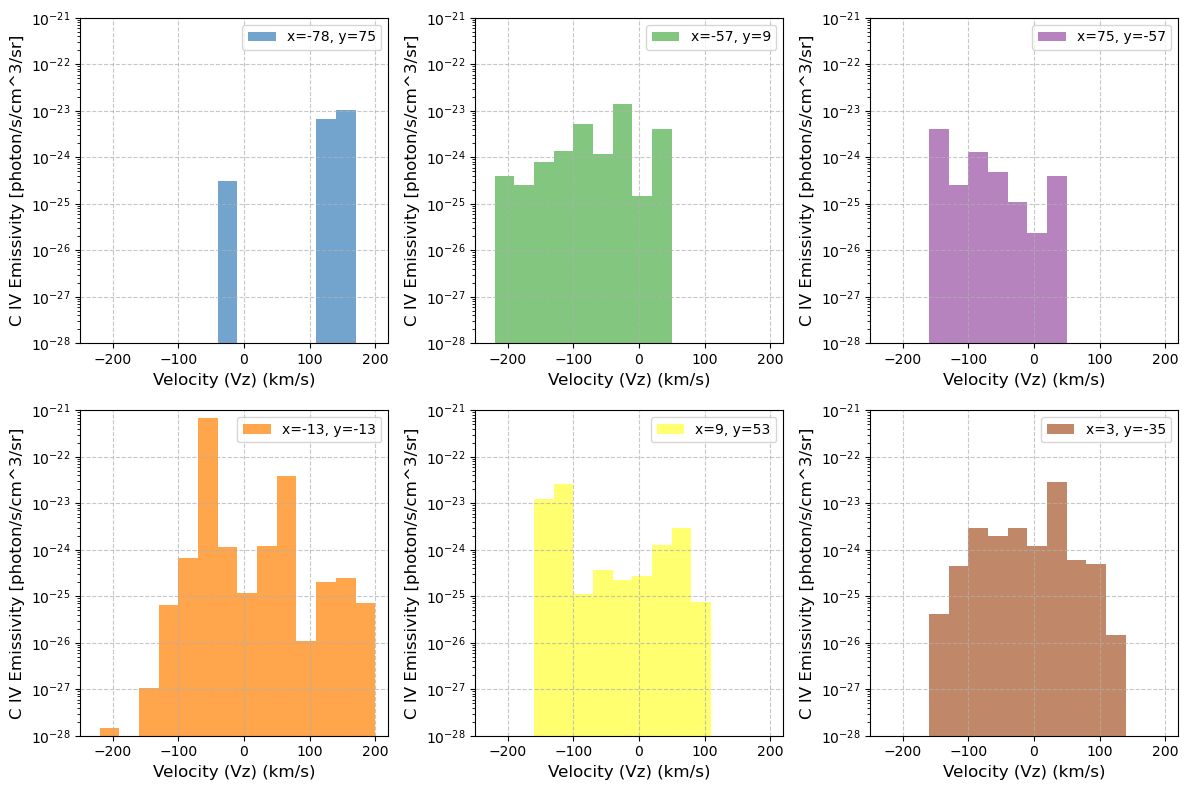

Processing ion: O VI (OVI)


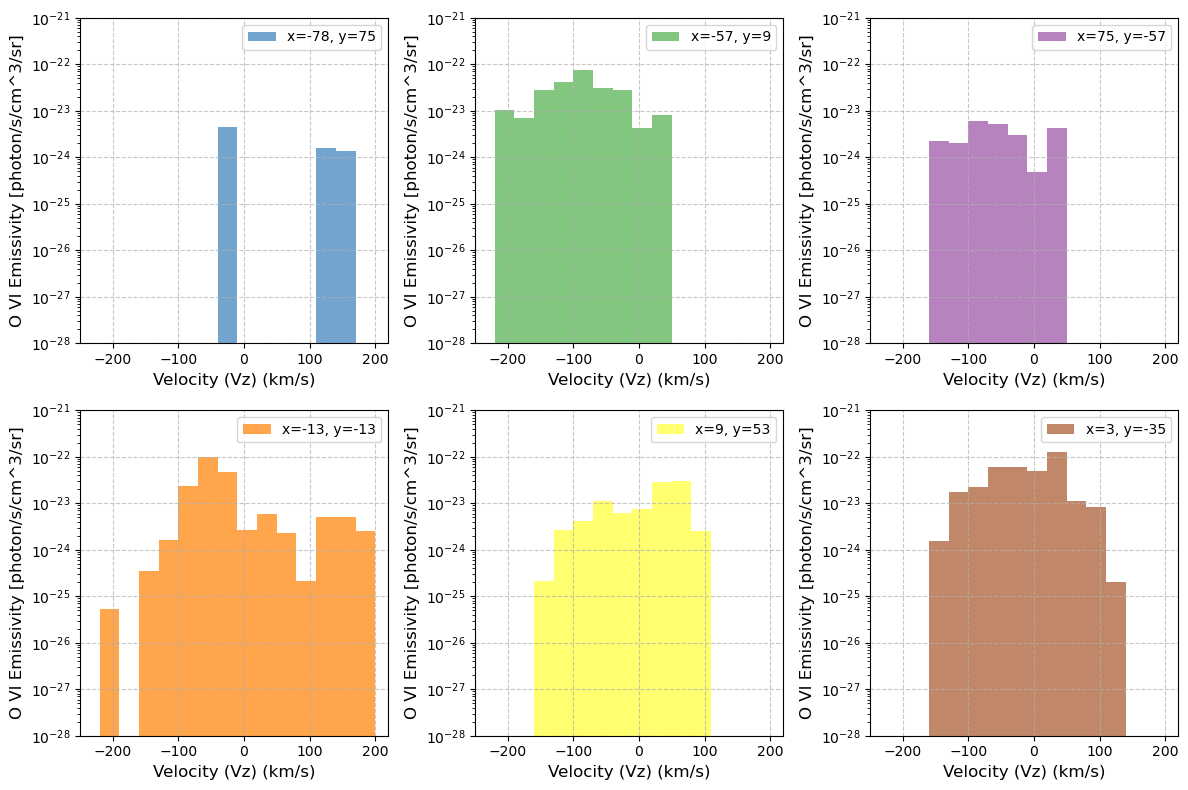

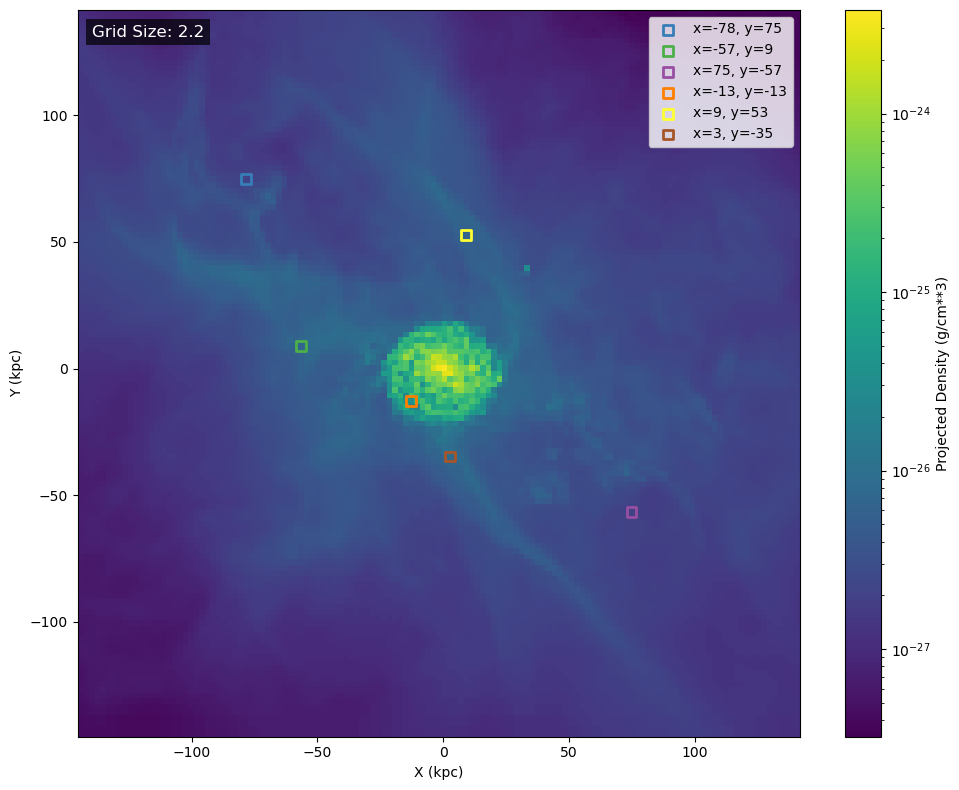

Processing ion: C IV


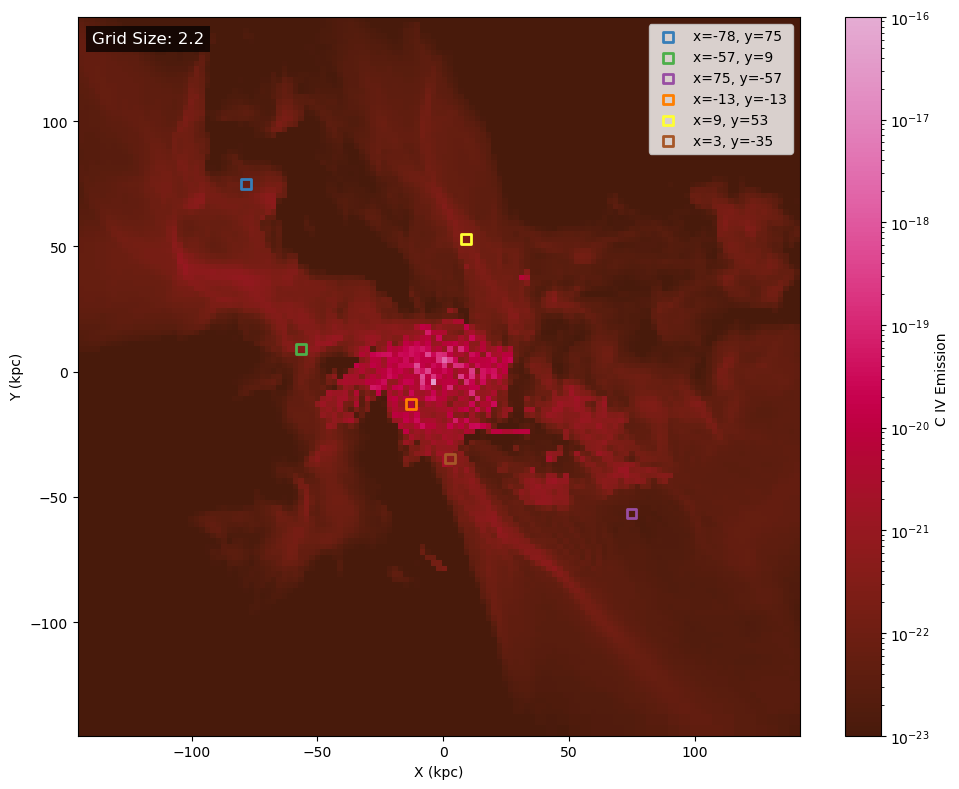

Processing ion: O VI


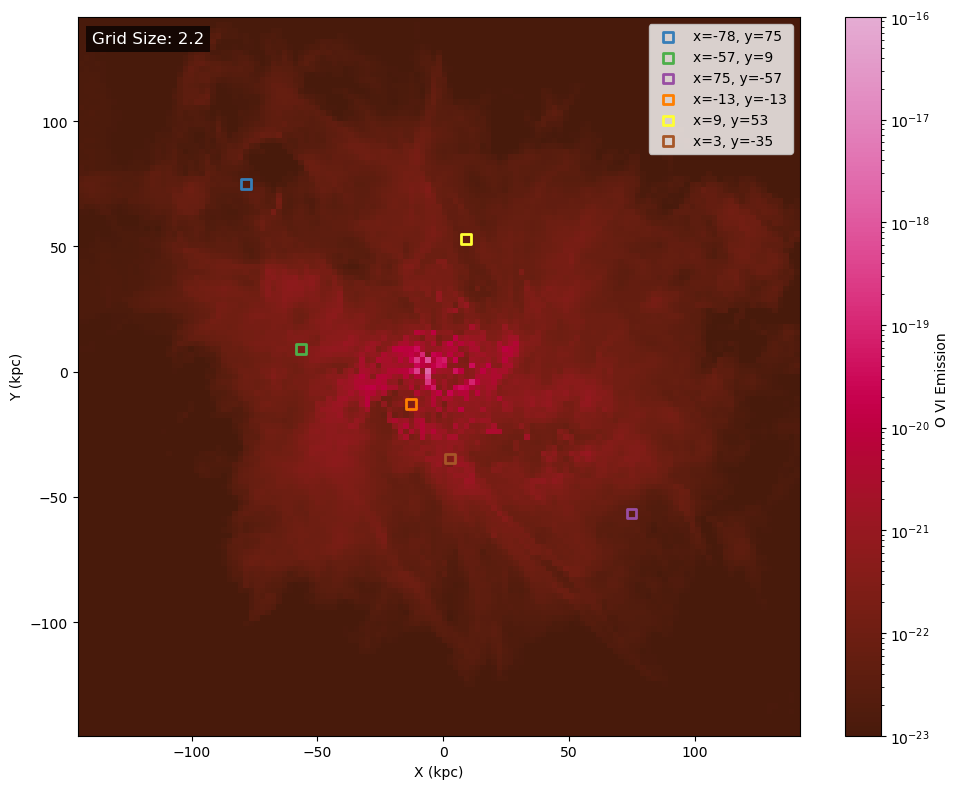

In [8]:
ds = load_and_calculate(snap, ions, unit_system='default', filter_type=None, filter_value=None, resolution=100)

In [9]:
# ###BACK - UP - DO NOT DELETE######

# def load_and_calculate(snap, ions, unit_system='default', filter_type=None, filter_value=None, resolution=100):

#     '''Loads the simulation snapshot and makes the requested plots, with optional filtering.'''

#     # Load simulation output
#     snap_name = foggie_dir + snap + '/' + snap
    
#     ds, refine_box = foggie_load(snap_name, trackname, do_filter_particles=True, halo_c_v_name=halo_c_v_name, disk_relative=True, correct_bulk_velocity=True)
#     zsnap = ds.get_parameter('CosmologyCurrentRedshift')
#     add_ion_fields(ds)

#     #make_fig(ds)
#     #FINAL VERSION OF CONVERTING HALO CENTER AND REFINMENT BOX WIDTH

#     # # Step 1: Ensure halo_center is in the same unit as ds.length_unit
#     # halo_center = ds.halo_center_kpc.in_units(ds.length_unit.units)

#     # # Step 2: Convert refine_width to code_length using ds.length_unit
#     # refine_width_kpc = YTQuantity(ds.refine_width, "kpc")
#     # refine_width_code_length = refine_width_kpc / ds.length_unit

#     # # Attach the length unit explicitly to refine_width_code_length
#     # refine_width_code_length = refine_width_code_length * ds.length_unit

#     # # convert from Mpccm/h to code_lenghth
#     # length_unit = ds.length_unit
#     # print(length_unit)
#     # halo_center = halo_center/length_unit
#     # refine_width = refine_width_code_length/length_unit

#     # print(halo_center)
#     # print(refine_width)
#     #covering_grid,halo_center_kpc,refinement_left_edge_kpc,refinement_right_edge_kpc,Grid_size = create_covering_grid(ds, halo_center, refine_width, level = 8)
    
        
#     #plot_emissivity_vs_velocity(covering_grid, halo_center_kpc, x_id_list, y_id_list,ions_dict, ion_field_names, save_path)

#     return(ds)
        
    

# if __name__ == "__main__":

    
#     # if ('feedback' in run) and ('track' in run):
#     #     foggie_dir = '/nobackup/jtumlins/halo_008508/feedback-track/'
#     #     run_dir = run + '/'
    
#     # Set directory for output location, making it if necessary
#     prefix = output_dir + 'ions_halo_00' + halo + '/' + run + '/'
#     if not (os.path.exists(prefix)): os.system('mkdir -p ' + prefix)
#     table_loc = prefix + 'Tables/'

#     print('foggie_dir: ', foggie_dir)
#     catalog_dir = code_path + 'halo_infos/00' + halo + '/' + run + '/'
#     halo_c_v_name = catalog_dir + 'halo_c_v'
#     #smooth_AM_name = catalog_dir + 'AM_direction_smoothed'

#     cloudy_path = code_path + "emission/cloudy_z0_selfshield/sh_z0_HM12_run%i.dat"
#     # These are the typical units that Lauren uses
#     # NOTE: This is a volumetric unit since it's for the emissivity of each cell
#     # Emission / surface brightness comes from the projections
#     emission_units = 's**-1 * cm**-3 * steradian**-1'
#     ytEmU = unyt.second**-1 * unyt.cm**-3 * unyt.steradian**-1

#     # These are a second set of units that a lot of observers prefer
#     # NOTE: This is a volumetric unit since it's for the emissivity of each cell
#     # Emission / surface brightness comes from the projections
#     emission_units_ALT = 'erg * s**-1 * cm**-3 * arcsec**-2'
#     ytEmUALT = unyt.erg * unyt.second**-1 * unyt.cm**-3 * unyt.arcsec**-2

#     ####################################
#     ## BEGIN CREATING EMISSION FIELDS ##
#     ####################################

#     # To make the emissivity fields, you need to follow a number of steps
#     # 1. Read in the Cloudy values for a given emission line
#     # 2. Create the n_H and T grids that represent the desired range of values
#     # 3. Set up interpolation function for the emissivity values across the grids
#     #    so the code can use the n_H and T values of a simulation grid cell to
#     #    interpolate the correct emissivity value
#     # 4. Define the emission field for the line
#     # 5. Add the line as a value in yt

#     ############################
#     # Function to register emission fields with unit options
#     def register_emission_field_with_unit(field_name, function, emission_units, unit_system):
#         yt.add_field(
#             ('gas', field_name),
#             units=emission_units if unit_system == 'default' else emission_units_ALT,
#             function=lambda field, data: function(field, data, unit_system=unit_system),
#             take_log=True,
#             force_override=True,
#             sampling_type='cell',
#         )
    
#     ############################
#     # Unit system setting (can be passed dynamically)
#     unit_system = 'default'  # Change this to 'ALT' as needed
    
#     ############################
#     # H-Alpha
#     hden_pts, T_pts, table_HA = make_Cloudy_table(2)
#     hden_pts, T_pts = np.meshgrid(hden_pts, T_pts)
#     pts = np.array((hden_pts.ravel(), T_pts.ravel())).T
    
#     sr_HA = table_HA.T.ravel()
#     bl_HA = interpolate.LinearNDInterpolator(pts, sr_HA)
#     register_emission_field_with_unit('Emission_HAlpha', _Emission_HAlpha, emission_units, unit_system)
    
#     ############################
#     # Ly-Alpha
#     hden_pts, T_pts, table_LA = make_Cloudy_table(1)
#     sr_LA = table_LA.T.ravel()
#     bl_LA = interpolate.LinearNDInterpolator(pts, sr_LA)
#     register_emission_field_with_unit('Emission_LyAlpha', _Emission_LyAlpha, emission_units, unit_system)
    
#     ############################
#     # CIII 977
#     hden_pts, T_pts, table_CIII_977 = make_Cloudy_table(7)
#     sr_CIII_977 = table_CIII_977.T.ravel()
#     bl_CIII_977 = interpolate.LinearNDInterpolator(pts, sr_CIII_977)
#     register_emission_field_with_unit('Emission_CIII_977', _Emission_CIII_977, emission_units, unit_system)

#     ############################
#     # CIII 1910
#     hden_pts, T_pts, table_CIII_1910 = make_Cloudy_table(9)
#     sr_CIII_1910 = table_CIII_1910.T.ravel()
#     bl_CIII_1910 = interpolate.LinearNDInterpolator(pts, sr_CIII_1910)
#     register_emission_field_with_unit('Emission_CIII_1910', _Emission_CIII_1910, emission_units, unit_system)

    
#     ############################
#     # CIV 1548
#     hden_pts, T_pts, table_CIV_1 = make_Cloudy_table(3)
#     sr_CIV_1 = table_CIV_1.T.ravel()
#     bl_CIV_1 = interpolate.LinearNDInterpolator(pts, sr_CIV_1)
#     register_emission_field_with_unit('Emission_CIV_1548', _Emission_CIV_1548, emission_units, unit_system)
    
#     ############################
#     # O VI (1032)
#     hden_pts, T_pts, table_OVI_1 = make_Cloudy_table(5)
#     sr_OVI_1 = table_OVI_1.T.ravel()
#     bl_OVI_1 = interpolate.LinearNDInterpolator(pts, sr_OVI_1)
    
#     register_emission_field_with_unit('Emission_OVI_1032', _Emission_OVI_1032, emission_units, unit_system)

#     ############################
#     # O VI (1038)
    
#     hden_pts, T_pts, table_OVI_2 = make_Cloudy_table(6)
#     sr_OVI_2 = table_OVI_2.T.ravel()
#     bl_OVI_2 = interpolate.LinearNDInterpolator(pts, sr_OVI_2)
#     register_emission_field_with_unit('Emission_OVI_1038', _Emission_OVI_1038, emission_units, unit_system)
    
#     ############################
#     # O VI (1032 and 1037 combined)
#     hden_pts, T_pts, table_OVI_1 = make_Cloudy_table(5)
#     hden_pts, T_pts, table_OVI_2 = make_Cloudy_table(6)
#     sr_OVI_1 = table_OVI_1.T.ravel()
#     sr_OVI_2 = table_OVI_2.T.ravel()
#     bl_OVI_1 = interpolate.LinearNDInterpolator(pts, sr_OVI_1)
#     bl_OVI_2 = interpolate.LinearNDInterpolator(pts, sr_OVI_2)
#     register_emission_field_with_unit('Emission_OVI', _Emission_OVI, emission_units, unit_system)
    
#     ############################
#     # SiIII 1207
#     cloudy_path_thin = code_path + "emission/cloudy_z0_HM05/bertone_run%i.dat"
#     hden_pts, T_pts, table_SiIII_1207 = make_Cloudy_table_thin(11)
#     hden_pts, T_pts = np.meshgrid(hden_pts, T_pts)
#     pts = np.array((hden_pts.ravel(), T_pts.ravel())).T
#     sr_SiIII_1207 = table_SiIII_1207.T.ravel()
#     bl_SiIII_1207 = interpolate.LinearNDInterpolator(pts, sr_SiIII_1207)
#     register_emission_field_with_unit('Emission_SiIII_1207', _Emission_SiIII_1207, emission_units, unit_system)



    
            



#     ##############################
#     #inputs:
#     x_id_list = [20, 40, 100, 60, 70, 67]
#     y_id_list = [20, 70, 40, 60, 90, 50]
#     ion_field_names = ions  # Add more ions as needed  
    
#     ions_dict = {'Lyalpha':'LyAlpha', 'Halpha':'HAlpha', 'C III':'CIII_1910',
#                  'C IV':'CIV_1548','O VI':'OVI', 'Si III':'SiIII_1207'}
#     ions_density_dict = {'Lyalpha':'LyAlpha', 'Halpha':'HAlpha', 'C III':'C_p2_density',
#                  'C IV':'C_p3_density','O VI':'O_p5_density', 'Si III':'Si_p2_density', 'Si II':'Si_p1_density', 'Si IV':'Si_p3_density','Mg II':'Mg_p1_density'}
    
#     label_dict = {'Lyalpha':r'Ly-$\alpha$', 'Halpha':r'H$\alpha$', 'C III':'C III',
#                 'C IV':'C IV','O VI':'O VI', 'Si III':'Si III'}
#     ion_mass_fields = {
#     "C IV": "C_p3_mass",
#     "O VI": "O_p5_mass"
# }

#     if unit_system  == 'default':
#         zlim_dict = {'Lyalpha':[1e-1,1e7], 'Halpha':[1e-1,1e6], 'C III':[1e-4,1e0],
#                  'C IV':[1e-2,1e4], 'O VI':[1e-2,1e5], 'Si III':[1e-1,1e4]}
#     elif unit_system == 'ALT':
#         zlim_dict = {'Lyalpha':[1e-22,1e-16], 'Halpha':[1e-22,1e-16], 'C III':[1e-26,1e-16],
#                  'C IV':[1e-23,1e-16], 'O VI':[1e-23,1e-16], 'Si III':[1e-22,1e16]}
    

#     ##############################
#     # Function to register velocity fields with unit options
# #     def register_velocity_field_with_unit(field_name, function,mass_field,comp):
# #         yt.add_field(
# #     ('gas', field_name),
# #     units="cm/s",
# #     function=lambda field, data: make_velocity_function(mass_field, comp)(field, data),
# #     take_log=True,
# #     force_override=True,
# #     sampling_type='cell',
# # )

# #     # ############################
# #     # Register thermal broadenning fields
# #     # for ion, mass_field in ion_mass_fields.items():
# #     #     register_velocity_field_with_unit(f"{ion}_thermal_broadening", ())
# #     ############################
# #     ## Register total velocity fields for each component
# #     velocity_components = ["vx_corrected", "vy_corrected", "vz_corrected"]

#     #################
#     # ion = 'C IV'
#     # mass_field = 'C_p3_mass'
#     # comp = "vx_corrected"
#     # register_velocity_field_with_unit("C IV_total_velocity_vz",make_velocity_function,mass_field,comp)

#     # Dynamically register fields with the factory function
#     # for ion, mass_field in ion_mass_fields.items():
#     #     for comp in velocity_components:
#     #         velocity_function = make_velocity_function(mass_field, comp)
#     #         register_velocity_field_with_unit(f"{ion}_total_velocity_{comp}", velocity_function, mass_field, comp)




#     #ds = load_and_calculate(snap, ions, unit_system='default', filter_type=None, filter_value=None, resolution=100)


#     # if not hasattr(ds, "derived_field_list"):
#     #     raise ValueError("The 'ds' object is not a valid yt dataset.")


#     # if ("gas", "C IV_total_velocity_vz") in ds.derived_field_list:
#     #     print(ds.field_info["gas", "C IV_total_velocity_vz"])
#     # else:
#     #     print("Field 'C IV_total_velocity_vz' is not registered.")

#     # Function to register a single velocity field
    

#     # Call this function after loading the dataset
#     ds = load_and_calculate(snap, ions, unit_system='default', filter_type=None, filter_value=None, resolution=100)

#     # Test registering a single velocity field
#     print("Testing velocity field registration...")
#     register_single_velocity_field(
#         ds=ds,
#         mass_field="C_p3_mass",       # Mass field for C IV
#         comp="vx_corrected",          # Velocity component
#         field_name="C IV_total_velocity_vx"
#     )

#     # Check if the field was successfully registered
#     if ("gas", "C IV_total_velocity_vx") in ds.derived_field_list:
#         print("Field 'C IV_total_velocity_vx' successfully registered.")
#     else:
#         print("Failed to register field 'C IV_total_velocity_vx'.")
    



   


    
        


        